In [23]:
import pandas as pd
import numpy as np
import matplotlib as plt
from skmultiflow.drift_detection import DDM
from skmultiflow.drift_detection import ADWIN
from skmultiflow.drift_detection import EDDM
from skmultiflow.drift_detection import PageHinkley
from skmultiflow.data import ConceptDriftStream
from skmultiflow.data import DataStream
import random
from numpy.random import choice

In [24]:
df = pd.read_csv('/Users/andrewyaholkovsky/Documents/Practicum/Data/motion_sense_combined_data/sub_1_combined_data.csv')
df.head()

,Unnamed: 0.1,Unnamed: 0,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z,type,outlier
0,0,0,1.528132,-0.733896,0.696372,0.741895,0.669768,-0.031672,0.316738,0.778180,1.082764,0.294894,-0.184493,0.377542,dws,0
1,1,1,1.527992,-0.716987,0.677762,0.753099,0.657116,-0.032255,0.842032,0.424446,0.643574,0.219405,0.035846,0.114866,dws,0
2,2,2,1.527765,-0.706999,0.670951,0.759611,0.649555,-0.032707,-0.138143,-0.040741,0.343563,0.010714,0.134701,-0.167808,dws,0
3,3,3,1.516768,-0.704678,0.675735,0.760709,0.647788,-0.041140,-0.025005,-1.048717,0.035860,-0.008389,0.136788,0.094958,dws,0
4,4,4,1.493941,-0.703918,0.672994,0.760062,0.647210,-0.058530,0.114253,-0.912890,0.047341,0.199441,0.353996,-0.044299,dws,0


In [25]:
#dropping outlier column
df = df.drop(columns = ['outlier','Unnamed: 0.1' ,'Unnamed: 0'])

#encode types to numbers
df['type'] = pd.factorize(df['type'])[0]+1

#shuffle dataset
df = df.sample(frac = 1)
df.head()

,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z,type
29557,-2.088800,-1.491767,-2.547842,-0.068590,0.996879,0.039090,-0.033050,-0.082641,-0.020399,0.031511,0.038720,-0.049497,4
48353,0.292536,-0.344447,-0.024322,0.271442,0.337676,-0.901273,0.030441,-0.010122,-0.027465,0.003216,0.000214,-0.005114,3
16016,0.322189,-0.338935,0.020371,0.298629,0.332482,-0.894581,0.021027,-0.011868,-0.015495,0.013733,0.006293,-0.005687,3
16589,0.336347,-0.340185,0.067467,0.311128,0.333662,-0.889871,0.140035,-0.272521,0.037904,-0.017610,-0.024106,0.019219,3
48006,0.214972,-0.468731,-0.098476,0.190312,0.451754,-0.871608,0.014180,-0.000422,0.001647,-0.000141,-0.008639,-0.012365,3


In [26]:
df.isna().sum()

attitude.roll         0
attitude.pitch        0
attitude.yaw          0
gravity.x             0
gravity.y             0
gravity.z             0
rotationRate.x        0
rotationRate.y        0
rotationRate.z        0
userAcceleration.x    0
userAcceleration.y    0
userAcceleration.z    0
type                  0
dtype: int64

In [27]:
df.shape

(62312, 13)

In [28]:
df.groupby(by='type').count()

,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z
type,,,,,,,,,,,,
1,5105,5105,5105,5105,5105,5105,5105,5105,5105,5105,5105,5105
2,6336,6336,6336,6336,6336,6336,6336,6336,6336,6336,6336,6336
3,20584,20584,20584,20584,20584,20584,20584,20584,20584,20584,20584,20584
4,12747,12747,12747,12747,12747,12747,12747,12747,12747,12747,12747,12747
5,11112,11112,11112,11112,11112,11112,11112,11112,11112,11112,11112,11112
6,6428,6428,6428,6428,6428,6428,6428,6428,6428,6428,6428,6428


In [29]:
number_of_classes = df['type'].nunique()
number_of_classes

6

## Sudden Drift Injection

In [30]:
def inject_sudden_drift (data, target_variable, task_type, drift_type, instances_of_drift, magnitude_of_drift, drift_length):
    
    df = data.copy(deep=True)
    
    drift_start_index = int(len(df)/2)
    
    #checking 
    
    if ((len(df)-drift_start_index)/drift_length) < instances_of_drift:
        print("Error: either reduce the drift_length or reduce instances_of_drift")
        return
    
    section_iterator = int(drift_start_index/instances_of_drift)
    
    target_variable_index = df.columns.get_loc(target_variable)
    
    
    if task_type == "classification":
        number_of_classes = df[target_variable].nunique()

        for i in range(instances_of_drift):
            for j in range(drift_length):

                df.iloc[(drift_start_index + (i*section_iterator))+j, target_variable_index] = random.randrange(number_of_classes)
            
    
    elif task_type == "regression":
        
        if magnitude_of_drift == "low":
            drift_amount = .5
        elif magnitude_of_drift == "medium":
            drift_amount = 1
        elif magnitude_of_drift == "high":
            drift_amount = 2

        for i in range(instances_of_drift):
            for j in range(drift_length):

                df.iloc[(drift_start_index + (i*section_iterator))+j, target_variable_index] = df.iloc[(drift_start_index + (i*section_iterator))+j, target_variable_index] * (1+drift_amount)
    
    return df


In [31]:
#original dataframe before drift injection

drift_start_index = int(len(df)/2)

df.iloc[drift_start_index:].head()

,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z,type
53694,0.330955,-0.340287,0.068453,0.306314,0.333758,-0.891503,0.004919,-0.008806,-0.009363,-0.010324,0.017774,-0.003227,3
55049,0.319103,-0.354463,0.073177,0.294212,0.347086,-0.890489,-0.043874,-0.076023,0.075226,0.021767,0.011480,-0.003081,3
24523,2.287109,-1.414153,1.563957,0.117662,0.987757,0.102433,-0.002564,-0.009319,-0.010590,-0.003862,0.005819,0.000060,4
60123,-0.618105,-1.361407,-1.920755,-0.120455,0.978158,-0.169404,2.173591,-0.590189,2.138214,0.214754,-0.092568,0.108857,5
59786,-0.514333,-1.337685,-1.917450,-0.113644,0.972952,-0.201118,2.287313,-1.321669,1.950719,0.052151,-0.290915,0.377907,5


In [32]:
#dataframe after drift injection

df_drift = inject_sudden_drift(df, "type", "classification", "sudden", 6, "high",1000)
df_drift.iloc[drift_start_index:].head()

,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z,type
53694,0.330955,-0.340287,0.068453,0.306314,0.333758,-0.891503,0.004919,-0.008806,-0.009363,-0.010324,0.017774,-0.003227,5
55049,0.319103,-0.354463,0.073177,0.294212,0.347086,-0.890489,-0.043874,-0.076023,0.075226,0.021767,0.011480,-0.003081,2
24523,2.287109,-1.414153,1.563957,0.117662,0.987757,0.102433,-0.002564,-0.009319,-0.010590,-0.003862,0.005819,0.000060,0
60123,-0.618105,-1.361407,-1.920755,-0.120455,0.978158,-0.169404,2.173591,-0.590189,2.138214,0.214754,-0.092568,0.108857,4
59786,-0.514333,-1.337685,-1.917450,-0.113644,0.972952,-0.201118,2.287313,-1.321669,1.950719,0.052151,-0.290915,0.377907,2


In [33]:
df_drift['type'].mean()

3.5039318269354216

In [34]:
df_drift_1 = inject_sudden_drift(df, "type", "classification", "sudden", 100, "high",100).reset_index(drop=True)
df_drift_2 = inject_sudden_drift(df, "type", "classification", "sudden", 100, "medium",100).reset_index(drop=True)
df_drift_3 = inject_sudden_drift(df, "type", "classification", "sudden", 100, "low",100).reset_index(drop=True)
df_drift_4 = inject_sudden_drift(df, "type", "classification", "sudden", 100, "high",250).reset_index(drop=True)
df_drift_5 = inject_sudden_drift(df, "type", "classification", "sudden", 100, "medium",250).reset_index(drop=True)
df_drift_6 = inject_sudden_drift(df, "type", "classification", "sudden", 100, "medium",250).reset_index(drop=True)

df_drift_7 = inject_gradual_drift(df, "type", "classification", "sudden", 100, "high",100).reset_index(drop=True)
df_drift_8 = inject_gradual_drift(df, "type", "classification", "sudden", 100, "medium",100).reset_index(drop=True)
df_drift_9 = inject_gradual_drift(df, "type", "classification", "sudden", 100, "low",100).reset_index(drop=True)
df_drift_10 = inject_gradual_drift(df, "type", "classification", "sudden", 100, "high",250).reset_index(drop=True)
df_drift_11 = inject_gradual_drift(df, "type", "classification", "sudden", 100, "medium",250).reset_index(drop=True)
df_drift_12 = inject_gradual_drift(df, "type", "classification", "sudden", 100, "low",250).reset_index(drop=True)


### Export for Yifei

In [102]:
df.to_csv("NoDrift.csv")

df_drift_1.to_csv("Sudden_high_100.csv")
df_drift_2.to_csv("Sudden_med_100.csv")
df_drift_3.to_csv("Sudden_low_100.csv")
df_drift_4.to_csv("Sudden_high_250.csv")
df_drift_5.to_csv("Sudden_med_250.csv")
df_drift_6.to_csv("Sudden_low_250.csv")

df_drift_7.to_csv("Gradual_high_100.csv")
df_drift_8.to_csv("Gradual_med_100.csv")
df_drift_9.to_csv("Gradual_low_100.csv")
df_drift_10.to_csv("Gradual_high_250.csv")
df_drift_11.to_csv("Gradual_med_250.csv")
df_drift_12.to_csv("Gradual_low_250.csv")


In [17]:
df_drift_temp = inject_sudden_drift(df, "type", "classification", "sudden", 30, "high",200)
tempdf = df_drift_temp.reset_index(drop=True).copy(deep=True)


df_drift_1_temp = tempdf['type'].copy(deep=True).to_frame("type1_drift")
df_drift_2_temp = tempdf['type'].copy(deep=True).to_frame("type2_drift")
df_drift_3_temp = tempdf['type'].copy(deep=True).to_frame("type3_drift")
df_drift_4_temp = tempdf['type'].copy(deep=True).to_frame("type4_drift")
df_drift_5_temp = tempdf['type'].copy(deep=True).to_frame("type5_drift")
df_drift_6_temp = tempdf['type'].copy(deep=True).to_frame("type6_drift")


df_drift_1_temp[df_drift_1_temp['type1_drift'].isin([2,3,4,5,6])]=0
df_drift_2_temp[df_drift_2_temp['type2_drift'].isin([1,3,4,5,6])]=0
df_drift_3_temp[df_drift_3_temp['type3_drift'].isin([1,2,4,5,6])]=0
df_drift_4_temp[df_drift_4_temp['type4_drift'].isin([1,2,3,5,6])]=0
df_drift_5_temp[df_drift_5_temp['type5_drift'].isin([1,2,3,4,6])]=0
df_drift_6_temp[df_drift_6_temp['type6_drift'].isin([1,2,3,4,5])]=0


df_drift_viz = pd.concat([tempdf, df_drift_1_temp,df_drift_2_temp,df_drift_3_temp,df_drift_4_temp,df_drift_5_temp,df_drift_6_temp], axis=1)
df_drift_viz

#df_drift_viz['type1_drift'].rolling(500).mean().reset_index(drop=True).plot(legend = True, title = "No Drift Rolling Average")
#df_drift_viz['type2_drift'].rolling(500).mean().reset_index(drop=True).plot(legend = True)
#df_drift_viz['type3_drift'].rolling(500).mean().reset_index(drop=True).plot(legend = True)
#df_drift_viz['type4_drift'].rolling(500).mean().reset_index(drop=True).plot(legend = True)
#df_drift_viz['type5_drift'].rolling(500).mean().reset_index(drop=True).plot(legend = True)
#df_drift_viz['type6_drift'].rolling(500).mean().reset_index(drop=True).plot(legend = True)

,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z,type,type1_drift,type2_drift,type3_drift,type4_drift,type5_drift,type6_drift
0,0.280070,-0.332934,0.001430,0.261244,0.326817,-0.908263,0.002840,-0.004201,0.010014,0.010591,0.006923,-0.006944,3,0,0,3,0,0,0
1,-0.529528,-1.359419,-1.814299,-0.105979,0.977743,-0.181073,2.095934,-0.781412,1.816006,0.043281,-0.247045,0.207959,5,0,0,0,0,5,0
2,2.014022,-1.428254,1.559043,0.128333,0.989858,0.060923,0.104764,0.055542,0.053579,-0.056342,0.033793,0.016103,4,0,0,0,4,0,0
3,1.539727,-0.716903,-2.335572,0.753481,0.657053,-0.023418,-0.037238,-0.867380,0.079251,0.343504,-0.164163,-0.345815,1,1,0,0,0,0,0
4,-0.631163,-1.452766,-0.960446,-0.069486,0.993043,-0.095070,-0.867006,2.492022,-3.336224,-2.105441,1.947341,-0.403252,6,0,0,0,0,0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62307,1.738787,-1.056548,1.798420,0.484956,0.870663,0.082243,0.015594,-0.067596,-0.008674,-0.016053,0.015812,0.020006,4,0,0,0,4,0,0
62308,1.715836,-1.074984,1.668376,0.470751,0.879583,0.068760,0.012609,0.001571,0.000148,0.009611,0.010081,-0.000080,4,0,0,0,4,0,0
62309,-1.734874,-1.454787,-2.687576,-0.114195,0.993278,0.018907,-0.313945,-0.566710,0.011712,0.066664,0.032661,-0.040727,1,1,0,0,0,0,0
62310,0.318659,-0.347619,0.048814,0.294554,0.340661,-0.892854,0.101037,-0.042533,0.018155,-0.016325,-0.015465,0.013612,3,0,0,3,0,0,0


In [18]:
df_drift_viz.to_csv("yifei_dataset_4.27_sudden30high200.csv")

In [21]:
df_drift_temp = inject_sudden_drift(df, "type", "classification", "sudden", 30, "medium",200)
tempdf = df_drift_temp.reset_index(drop=True).copy(deep=True)


df_drift_1_temp = tempdf['type'].copy(deep=True).to_frame("type1_drift")
df_drift_2_temp = tempdf['type'].copy(deep=True).to_frame("type2_drift")
df_drift_3_temp = tempdf['type'].copy(deep=True).to_frame("type3_drift")
df_drift_4_temp = tempdf['type'].copy(deep=True).to_frame("type4_drift")
df_drift_5_temp = tempdf['type'].copy(deep=True).to_frame("type5_drift")
df_drift_6_temp = tempdf['type'].copy(deep=True).to_frame("type6_drift")


df_drift_1_temp[df_drift_1_temp['type1_drift'].isin([2,3,4,5,6])]=0
df_drift_2_temp[df_drift_2_temp['type2_drift'].isin([1,3,4,5,6])]=0
df_drift_3_temp[df_drift_3_temp['type3_drift'].isin([1,2,4,5,6])]=0
df_drift_4_temp[df_drift_4_temp['type4_drift'].isin([1,2,3,5,6])]=0
df_drift_5_temp[df_drift_5_temp['type5_drift'].isin([1,2,3,4,6])]=0
df_drift_6_temp[df_drift_6_temp['type6_drift'].isin([1,2,3,4,5])]=0


df_drift_viz = pd.concat([tempdf, df_drift_1_temp,df_drift_2_temp,df_drift_3_temp,df_drift_4_temp,df_drift_5_temp,df_drift_6_temp], axis=1)
df_drift_viz

#df_drift_viz['type1_drift'].rolling(500).mean().reset_index(drop=True).plot(legend = True, title = "No Drift Rolling Average")
#df_drift_viz['type2_drift'].rolling(500).mean().reset_index(drop=True).plot(legend = True)
#df_drift_viz['type3_drift'].rolling(500).mean().reset_index(drop=True).plot(legend = True)
#df_drift_viz['type4_drift'].rolling(500).mean().reset_index(drop=True).plot(legend = True)
#df_drift_viz['type5_drift'].rolling(500).mean().reset_index(drop=True).plot(legend = True)
#df_drift_viz['type6_drift'].rolling(500).mean().reset_index(drop=True).plot(legend = True)

df_drift_viz.to_csv("yifei_dataset_4.27_sudden30medium200.csv")

### Visualization of Sudden Drift

In [35]:
df_nodrift_1 = df['type'].copy(deep=True).to_frame("type1")
df_nodrift_2 = df['type'].copy(deep=True).to_frame("type2")
df_nodrift_3 = df['type'].copy(deep=True).to_frame("type3")
df_nodrift_4 = df['type'].copy(deep=True).to_frame("type4")
df_nodrift_5 = df['type'].copy(deep=True).to_frame("type5")
df_nodrift_6 = df['type'].copy(deep=True).to_frame("type6")


df_nodrift_1[df_nodrift_1['type1'].isin([2,3,4,5,6])]=0
df_nodrift_2[df_nodrift_2['type2'].isin([1,3,4,5,6])]=0
df_nodrift_3[df_nodrift_3['type3'].isin([1,2,4,5,6])]=0
df_nodrift_4[df_nodrift_4['type4'].isin([1,2,3,5,6])]=0
df_nodrift_5[df_nodrift_5['type5'].isin([1,2,3,4,6])]=0
df_nodrift_6[df_nodrift_6['type6'].isin([1,2,3,4,5])]=0


df_nodrift_viz = pd.concat([df, df_nodrift_1,df_nodrift_2,df_nodrift_3,df_nodrift_4,df_nodrift_5,df_nodrift_6], axis=1)


<AxesSubplot:title={'center':'No Drift Rolling Average'}>

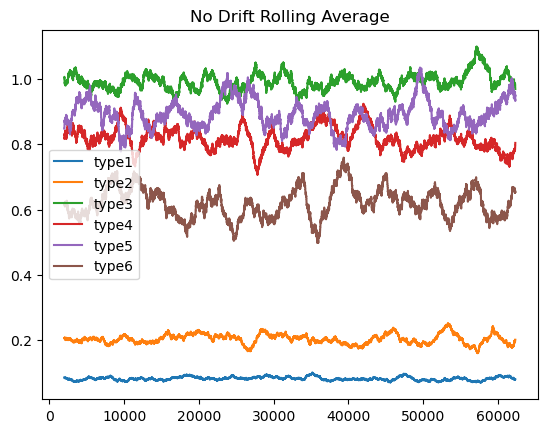

In [36]:
df_nodrift_viz['type1'].rolling(2000).mean().reset_index(drop=True).plot(legend = True,title = "No Drift Rolling Average")
df_nodrift_viz['type2'].rolling(2000).mean().reset_index(drop=True).plot(legend = True)
df_nodrift_viz['type3'].rolling(2000).mean().reset_index(drop=True).plot(legend = True)
df_nodrift_viz['type4'].rolling(2000).mean().reset_index(drop=True).plot(legend = True)
df_nodrift_viz['type5'].rolling(2000).mean().reset_index(drop=True).plot(legend = True)
df_nodrift_viz['type6'].rolling(2000).mean().reset_index(drop=True).plot(legend = True)

In [37]:
df_drift_1 = df_drift['type'].copy(deep=True).to_frame("type1_drift")
df_drift_2 = df_drift['type'].copy(deep=True).to_frame("type2_drift")
df_drift_3 = df_drift['type'].copy(deep=True).to_frame("type3_drift")
df_drift_4 = df_drift['type'].copy(deep=True).to_frame("type4_drift")
df_drift_5 = df_drift['type'].copy(deep=True).to_frame("type5_drift")
df_drift_6 = df_drift['type'].copy(deep=True).to_frame("type6_drift")


df_drift_1[df_drift_1['type1_drift'].isin([2,3,4,5,6])]=0
df_drift_2[df_drift_2['type2_drift'].isin([1,3,4,5,6])]=0
df_drift_3[df_drift_3['type3_drift'].isin([1,2,4,5,6])]=0
df_drift_4[df_drift_4['type4_drift'].isin([1,2,3,5,6])]=0
df_drift_5[df_drift_5['type5_drift'].isin([1,2,3,4,6])]=0
df_drift_6[df_drift_6['type6_drift'].isin([1,2,3,4,5])]=0


df_drift_viz = pd.concat([df_drift, df_drift_1,df_drift_2,df_drift_3,df_drift_4,df_drift_5,df_drift_6], axis=1)

In [38]:
df_drift_viz

,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z,type,type1_drift,type2_drift,type3_drift,type4_drift,type5_drift,type6_drift
29557,-2.088800,-1.491767,-2.547842,-0.068590,0.996879,0.039090,-0.033050,-0.082641,-0.020399,0.031511,0.038720,-0.049497,4,0,0,0,4,0,0
48353,0.292536,-0.344447,-0.024322,0.271442,0.337676,-0.901273,0.030441,-0.010122,-0.027465,0.003216,0.000214,-0.005114,3,0,0,3,0,0,0
16016,0.322189,-0.338935,0.020371,0.298629,0.332482,-0.894581,0.021027,-0.011868,-0.015495,0.013733,0.006293,-0.005687,3,0,0,3,0,0,0
16589,0.336347,-0.340185,0.067467,0.311128,0.333662,-0.889871,0.140035,-0.272521,0.037904,-0.017610,-0.024106,0.019219,3,0,0,3,0,0,0
48006,0.214972,-0.468731,-0.098476,0.190312,0.451754,-0.871608,0.014180,-0.000422,0.001647,-0.000141,-0.008639,-0.012365,3,0,0,3,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47571,0.210402,-0.447300,-0.075545,0.188306,0.432533,-0.881735,-0.024135,0.001653,0.019978,-0.000882,0.003487,-0.004480,3,0,0,3,0,0,0
47993,0.215864,-0.474918,-0.097344,0.190487,0.457266,-0.868690,0.014100,-0.009915,-0.005882,0.000858,0.008982,-0.011452,3,0,0,3,0,0,0
35640,0.398547,-1.247550,0.096487,0.123272,0.948209,-0.292751,-2.749857,-0.090398,-0.822396,0.192249,-0.327268,-0.541035,5,0,0,0,0,5,0
20201,2.502705,-1.398313,1.913925,0.102343,0.985162,0.137777,0.012900,-0.014866,0.007833,0.017423,0.013099,-0.000219,4,0,0,0,4,0,0


#### Comparing different rolling averages

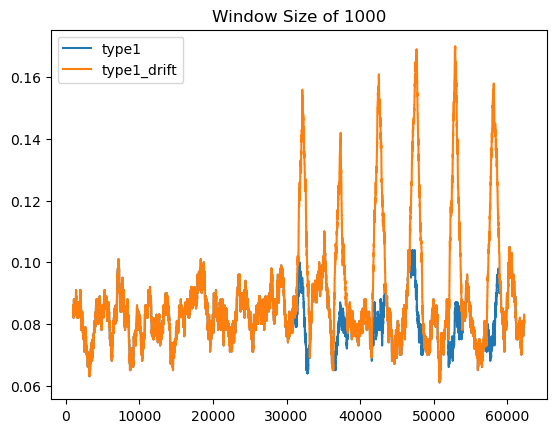

In [41]:
import matplotlib.pyplot as plt
df_nodrift_viz['type1'].rolling(1000).mean().reset_index(drop=True).plot(legend=True, title = "Window Size of 1000")
df_drift_viz['type1_drift'].rolling(1000).mean().reset_index(drop=True).plot(legend=True)
plt.savefig("DriftInjectionExample.png")

<AxesSubplot:title={'center':'Window Size of 500'}>

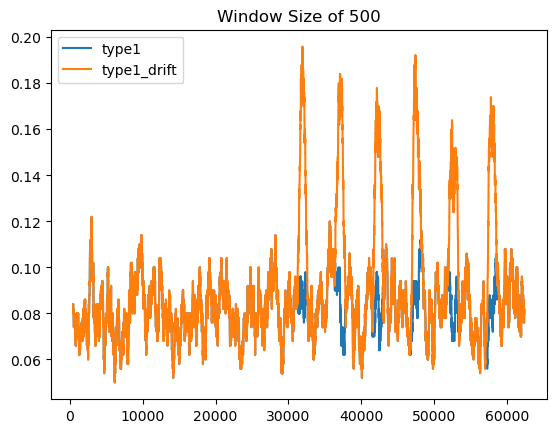

In [18]:
df_nodrift_viz['type1'].rolling(500).mean().reset_index(drop=True).plot(legend=True, title = "Window Size of 500")
df_drift_viz['type1_drift'].rolling(500).mean().reset_index(drop=True).plot(legend=True)

<AxesSubplot:title={'center':'Window Size of 100'}>

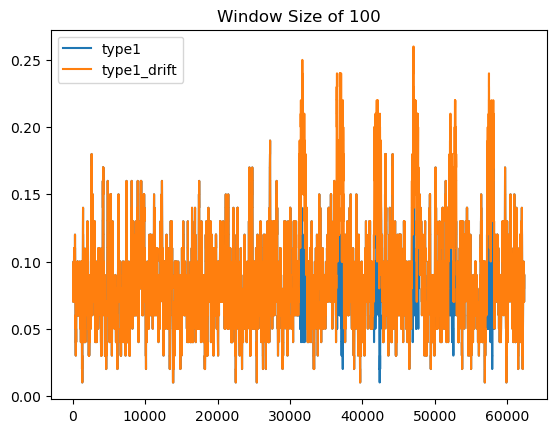

In [19]:
df_nodrift_viz['type1'].rolling(100).mean().reset_index(drop=True).plot(legend=True, title = "Window Size of 100")
df_drift_viz['type1_drift'].rolling(100).mean().reset_index(drop=True).plot(legend=True)

Experiment with window functions (in this case, exponential)

<AxesSubplot:>

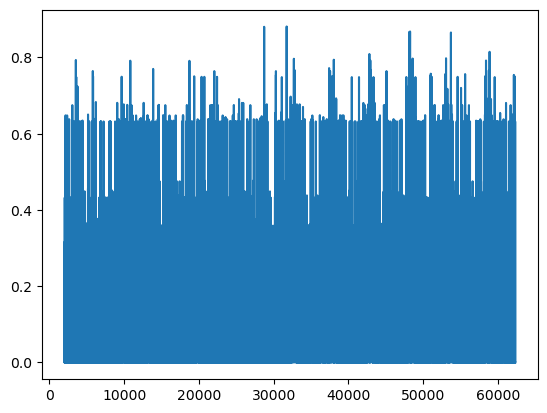

In [20]:
df_drift_viz['type1_drift'].rolling(2000,win_type='exponential').mean().reset_index(drop=True).plot()

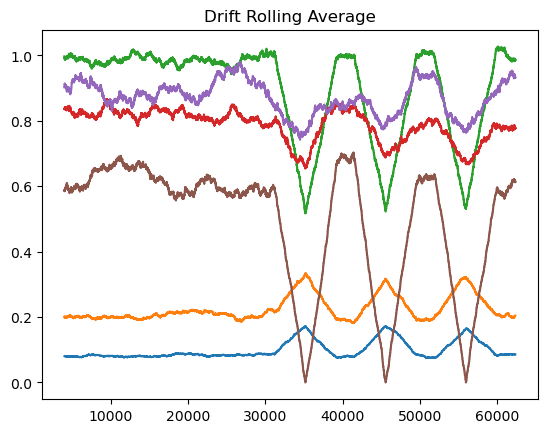

In [42]:
df_drift = inject_sudden_drift(df, "type", "classification", "sudden", 3, "medium",4000)

df_drift_1 = df_drift['type'].copy(deep=True).to_frame("type1_drift")
df_drift_2 = df_drift['type'].copy(deep=True).to_frame("type2_drift")
df_drift_3 = df_drift['type'].copy(deep=True).to_frame("type3_drift")
df_drift_4 = df_drift['type'].copy(deep=True).to_frame("type4_drift")
df_drift_5 = df_drift['type'].copy(deep=True).to_frame("type5_drift")
df_drift_6 = df_drift['type'].copy(deep=True).to_frame("type6_drift")


df_drift_1[df_drift_1['type1_drift'].isin([2,3,4,5,6])]=0
df_drift_2[df_drift_2['type2_drift'].isin([1,3,4,5,6])]=0
df_drift_3[df_drift_3['type3_drift'].isin([1,2,4,5,6])]=0
df_drift_4[df_drift_4['type4_drift'].isin([1,2,3,5,6])]=0
df_drift_5[df_drift_5['type5_drift'].isin([1,2,3,4,6])]=0
df_drift_6[df_drift_6['type6_drift'].isin([1,2,3,4,5])]=0


df_drift_viz = pd.concat([df_drift, df_drift_1,df_drift_2,df_drift_3,df_drift_4,df_drift_5,df_drift_6], axis=1)

df_drift_viz['type1_drift'].rolling(4000).mean().reset_index(drop=True).plot(title = "Drift Rolling Average")
df_drift_viz['type2_drift'].rolling(4000).mean().reset_index(drop=True).plot()
df_drift_viz['type3_drift'].rolling(4000).mean().reset_index(drop=True).plot()
df_drift_viz['type4_drift'].rolling(4000).mean().reset_index(drop=True).plot()
df_drift_viz['type5_drift'].rolling(4000).mean().reset_index(drop=True).plot()
df_drift_viz['type6_drift'].rolling(4000).mean().reset_index(drop=True).plot()



plt.savefig("InjectedDriftbyExerciseType.png")

<AxesSubplot:title={'center':'Drift Rolling Average'}>

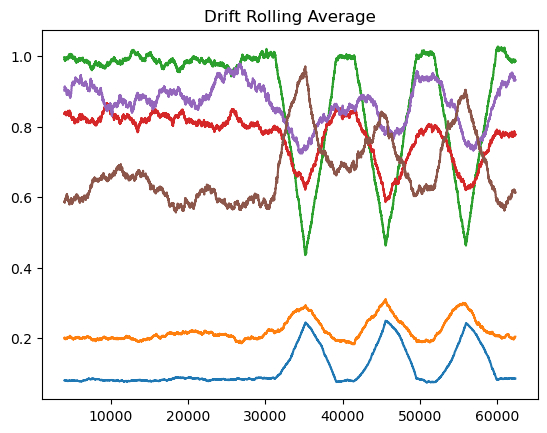

In [43]:

#dataframe after drift injection

df_drift = inject_gradual_drift(df, "type", "classification", "sudden", 3, "medium",4000)
df_drift.iloc[drift_start_index:].head()

df_drift_1 = df_drift['type'].copy(deep=True).to_frame("type1_drift")
df_drift_2 = df_drift['type'].copy(deep=True).to_frame("type2_drift")
df_drift_3 = df_drift['type'].copy(deep=True).to_frame("type3_drift")
df_drift_4 = df_drift['type'].copy(deep=True).to_frame("type4_drift")
df_drift_5 = df_drift['type'].copy(deep=True).to_frame("type5_drift")
df_drift_6 = df_drift['type'].copy(deep=True).to_frame("type6_drift")


df_drift_1[df_drift_1['type1_drift'].isin([2,3,4,5,6])]=0
df_drift_2[df_drift_2['type2_drift'].isin([1,3,4,5,6])]=0
df_drift_3[df_drift_3['type3_drift'].isin([1,2,4,5,6])]=0
df_drift_4[df_drift_4['type4_drift'].isin([1,2,3,5,6])]=0
df_drift_5[df_drift_5['type5_drift'].isin([1,2,3,4,6])]=0
df_drift_6[df_drift_6['type6_drift'].isin([1,2,3,4,5])]=0


df_drift_viz = pd.concat([df_drift, df_drift_1,df_drift_2,df_drift_3,df_drift_4,df_drift_5,df_drift_6], axis=1)

df_drift_viz['type1_drift'].rolling(4000).mean().reset_index(drop=True).plot(title = "Drift Rolling Average")
df_drift_viz['type2_drift'].rolling(4000).mean().reset_index(drop=True).plot()
df_drift_viz['type3_drift'].rolling(4000).mean().reset_index(drop=True).plot()
df_drift_viz['type4_drift'].rolling(4000).mean().reset_index(drop=True).plot()
df_drift_viz['type5_drift'].rolling(4000).mean().reset_index(drop=True).plot()
df_drift_viz['type6_drift'].rolling(4000).mean().reset_index(drop=True).plot()

## Inject Gradual Drift

In [14]:
def inject_gradual_drift (data, target_variable, task_type, drift_type, instances_of_drift, magnitude_of_drift, drift_length):
    
    df = data.copy(deep=True)
    
    drift_start_index = int(len(df)/2)
    
    section_iterator = int(drift_start_index/instances_of_drift)
    
    target_variable_index = df.columns.get_loc(target_variable)
    
    
    if task_type == "classification":
        number_of_classes = df[target_variable].nunique()

    if ((len(df)-drift_start_index)/drift_length) < instances_of_drift:
        print("Error: either reduce the drift_length or reduce instances_of_drift")
        return    

    #gradual drift
    
    probability_if_random = 1/number_of_classes
    
    if magnitude_of_drift == "low":
        drift_amount = .5
    elif magnitude_of_drift == "medium":
        drift_amount = 1
    elif magnitude_of_drift == "high":
        drift_amount = 2
    
    
    class_list = []
    for i in range(number_of_classes):
        class_list.append(i+1)
        
    
    if task_type == "regression":
    

        for i in range(instances_of_drift):
            for j in range(drift_length):


                    df.iloc[(drift_start_index + (i*section_iterator))+j, target_variable_index] = df.iloc[(drift_start_index + (i*section_iterator))+j, target_variable_index] * [1+((drift_amount * j)/drift_length)]


    
    if task_type == "classification":

    
        for i in range(instances_of_drift):
            for j in range(drift_length):

                    class1_prob = probability_if_random + ((drift_amount * j)/drift_length*probability_if_random)

                    class_prob_list = []
                    for k in range(number_of_classes):
                        if k == 0:
                            class_prob_list.append(class1_prob)
                        else:
                            class_prob_list.append((1-class1_prob)/(number_of_classes-1))


                    df.iloc[(drift_start_index + (i*section_iterator))+j, target_variable_index] = np.random.choice(class_list,1,p=class_prob_list)

    return df


In [19]:
df_drift_temp = inject_gradual_drift(df, "type", "classification", "sudden", 30, "high",200)
tempdf = df_drift_temp.reset_index(drop=True).copy(deep=True)


df_drift_1_temp = tempdf['type'].copy(deep=True).to_frame("type1_drift")
df_drift_2_temp = tempdf['type'].copy(deep=True).to_frame("type2_drift")
df_drift_3_temp = tempdf['type'].copy(deep=True).to_frame("type3_drift")
df_drift_4_temp = tempdf['type'].copy(deep=True).to_frame("type4_drift")
df_drift_5_temp = tempdf['type'].copy(deep=True).to_frame("type5_drift")
df_drift_6_temp = tempdf['type'].copy(deep=True).to_frame("type6_drift")


df_drift_1_temp[df_drift_1_temp['type1_drift'].isin([2,3,4,5,6])]=0
df_drift_2_temp[df_drift_2_temp['type2_drift'].isin([1,3,4,5,6])]=0
df_drift_3_temp[df_drift_3_temp['type3_drift'].isin([1,2,4,5,6])]=0
df_drift_4_temp[df_drift_4_temp['type4_drift'].isin([1,2,3,5,6])]=0
df_drift_5_temp[df_drift_5_temp['type5_drift'].isin([1,2,3,4,6])]=0
df_drift_6_temp[df_drift_6_temp['type6_drift'].isin([1,2,3,4,5])]=0


df_drift_viz = pd.concat([tempdf, df_drift_1_temp,df_drift_2_temp,df_drift_3_temp,df_drift_4_temp,df_drift_5_temp,df_drift_6_temp], axis=1)
df_drift_viz

#df_drift_viz['type1_drift'].rolling(500).mean().reset_index(drop=True).plot(legend = True, title = "No Drift Rolling Average")
#df_drift_viz['type2_drift'].rolling(500).mean().reset_index(drop=True).plot(legend = True)
#df_drift_viz['type3_drift'].rolling(500).mean().reset_index(drop=True).plot(legend = True)
#df_drift_viz['type4_drift'].rolling(500).mean().reset_index(drop=True).plot(legend = True)
#df_drift_viz['type5_drift'].rolling(500).mean().reset_index(drop=True).plot(legend = True)
#df_drift_viz['type6_drift'].rolling(500).mean().reset_index(drop=True).plot(legend = True)

,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z,type,type1_drift,type2_drift,type3_drift,type4_drift,type5_drift,type6_drift
0,0.280070,-0.332934,0.001430,0.261244,0.326817,-0.908263,0.002840,-0.004201,0.010014,0.010591,0.006923,-0.006944,3,0,0,3,0,0,0
1,-0.529528,-1.359419,-1.814299,-0.105979,0.977743,-0.181073,2.095934,-0.781412,1.816006,0.043281,-0.247045,0.207959,5,0,0,0,0,5,0
2,2.014022,-1.428254,1.559043,0.128333,0.989858,0.060923,0.104764,0.055542,0.053579,-0.056342,0.033793,0.016103,4,0,0,0,4,0,0
3,1.539727,-0.716903,-2.335572,0.753481,0.657053,-0.023418,-0.037238,-0.867380,0.079251,0.343504,-0.164163,-0.345815,1,1,0,0,0,0,0
4,-0.631163,-1.452766,-0.960446,-0.069486,0.993043,-0.095070,-0.867006,2.492022,-3.336224,-2.105441,1.947341,-0.403252,6,0,0,0,0,0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62307,1.738787,-1.056548,1.798420,0.484956,0.870663,0.082243,0.015594,-0.067596,-0.008674,-0.016053,0.015812,0.020006,4,0,0,0,4,0,0
62308,1.715836,-1.074984,1.668376,0.470751,0.879583,0.068760,0.012609,0.001571,0.000148,0.009611,0.010081,-0.000080,4,0,0,0,4,0,0
62309,-1.734874,-1.454787,-2.687576,-0.114195,0.993278,0.018907,-0.313945,-0.566710,0.011712,0.066664,0.032661,-0.040727,1,1,0,0,0,0,0
62310,0.318659,-0.347619,0.048814,0.294554,0.340661,-0.892854,0.101037,-0.042533,0.018155,-0.016325,-0.015465,0.013612,3,0,0,3,0,0,0


In [20]:
df_drift_viz.to_csv("yifei_dataset_4.27_gradual30high200.csv")

In [24]:
df_drift = inject_gradual_drift(df, "type", "classification", "sudden", 6, "high",1000)

df_drift_1 = df_drift['type'].copy(deep=True).to_frame("type1_drift")
df_drift_2 = df_drift['type'].copy(deep=True).to_frame("type2_drift")
df_drift_3 = df_drift['type'].copy(deep=True).to_frame("type3_drift")
df_drift_4 = df_drift['type'].copy(deep=True).to_frame("type4_drift")
df_drift_5 = df_drift['type'].copy(deep=True).to_frame("type5_drift")
df_drift_6 = df_drift['type'].copy(deep=True).to_frame("type6_drift")


df_drift_1[df_drift_1['type1_drift'].isin([2,3,4,5,6])]=0
df_drift_2[df_drift_2['type2_drift'].isin([1,3,4,5,6])]=0
df_drift_3[df_dribft_3['type3_drift'].isin([1,2,4,5,6])]=0
df_drift_4[df_drift_4['type4_drift'].isin([1,2,3,5,6])]=0
df_drift_5[df_drift_5['type5_drift'].isin([1,2,3,4,6])]=0
df_drift_6[df_drift_6['type6_drift'].isin([1,2,3,4,5])]=0


df_drift_viz = pd.concat([df_drift, df_drift_1,df_drift_2,df_drift_3,df_drift_4,df_drift_5,df_drift_6], axis=1)

df_drift_viz['type1_drift'].rolling(2000).mean().reset_index(drop=True).plot(title = "Drift Rolling Average")
df_drift_viz['type2_drift'].rolling(2000).mean().reset_index(drop=True).plot()
df_drift_viz['type3_drift'].rolling(2000).mean().reset_index(drop=True).plot()
df_drift_viz['type4_drift'].rolling(2000).mean().reset_index(drop=True).plot()
df_drift_viz['type5_drift'].rolling(2000).mean().reset_index(drop=True).plot()
df_drift_viz['type6_drift'].rolling(2000).mean().reset_index(drop=True).plot()

NameError: name 'df_dribft_3' is not defined

<AxesSubplot:title={'center':'Drift Rolling Average'}>

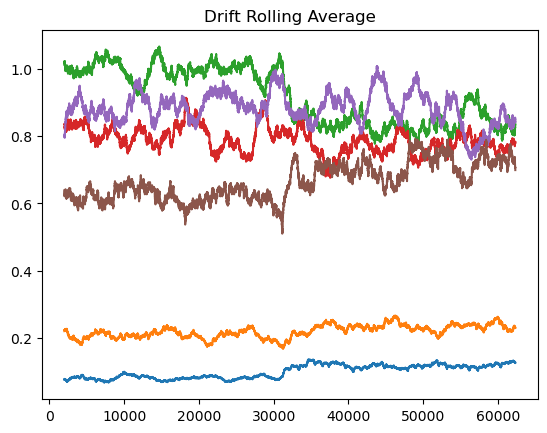

In [25]:
df_drift = inject_gradual_drift(df, "type", "classification", "sudden", 30, "low",300)
df_drift.iloc[drift_start_index:].head()

df_drift_1 = df_drift['type'].copy(deep=True).to_frame("type1_drift")
df_drift_2 = df_drift['type'].copy(deep=True).to_frame("type2_drift")
df_drift_3 = df_drift['type'].copy(deep=True).to_frame("type3_drift")
df_drift_4 = df_drift['type'].copy(deep=True).to_frame("type4_drift")
df_drift_5 = df_drift['type'].copy(deep=True).to_frame("type5_drift")
df_drift_6 = df_drift['type'].copy(deep=True).to_frame("type6_drift")


df_drift_1[df_drift_1['type1_drift'].isin([2,3,4,5,6])]=0
df_drift_2[df_drift_2['type2_drift'].isin([1,3,4,5,6])]=0
df_drift_3[df_drift_3['type3_drift'].isin([1,2,4,5,6])]=0
df_drift_4[df_drift_4['type4_drift'].isin([1,2,3,5,6])]=0
df_drift_5[df_drift_5['type5_drift'].isin([1,2,3,4,6])]=0
df_drift_6[df_drift_6['type6_drift'].isin([1,2,3,4,5])]=0


df_drift_viz = pd.concat([df_drift, df_drift_1,df_drift_2,df_drift_3,df_drift_4,df_drift_5,df_drift_6], axis=1)

df_drift_viz['type1_drift'].rolling(2000).mean().reset_index(drop=True).plot(title = "Drift Rolling Average")
df_drift_viz['type2_drift'].rolling(2000).mean().reset_index(drop=True).plot()
df_drift_viz['type3_drift'].rolling(2000).mean().reset_index(drop=True).plot()
df_drift_viz['type4_drift'].rolling(2000).mean().reset_index(drop=True).plot()
df_drift_viz['type5_drift'].rolling(2000).mean().reset_index(drop=True).plot()
df_drift_viz['type6_drift'].rolling(2000).mean().reset_index(drop=True).plot()

<AxesSubplot:title={'center':'Drift Rolling Average'}>

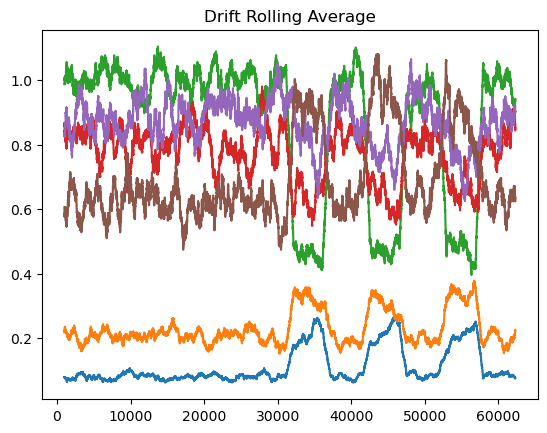

In [26]:

#dataframe after drift injection

df_drift = inject_gradual_drift(df, "type", "classification", "sudden", 3, "low",5000)
df_drift.iloc[drift_start_index:].head()

df_drift_1 = df_drift['type'].copy(deep=True).to_frame("type1_drift")
df_drift_2 = df_drift['type'].copy(deep=True).to_frame("type2_drift")
df_drift_3 = df_drift['type'].copy(deep=True).to_frame("type3_drift")
df_drift_4 = df_drift['type'].copy(deep=True).to_frame("type4_drift")
df_drift_5 = df_drift['type'].copy(deep=True).to_frame("type5_drift")
df_drift_6 = df_drift['type'].copy(deep=True).to_frame("type6_drift")


df_drift_1[df_drift_1['type1_drift'].isin([2,3,4,5,6])]=0
df_drift_2[df_drift_2['type2_drift'].isin([1,3,4,5,6])]=0
df_drift_3[df_drift_3['type3_drift'].isin([1,2,4,5,6])]=0
df_drift_4[df_drift_4['type4_drift'].isin([1,2,3,5,6])]=0
df_drift_5[df_drift_5['type5_drift'].isin([1,2,3,4,6])]=0
df_drift_6[df_drift_6['type6_drift'].isin([1,2,3,4,5])]=0


df_drift_viz = pd.concat([df_drift, df_drift_1,df_drift_2,df_drift_3,df_drift_4,df_drift_5,df_drift_6], axis=1)

df_drift_viz['type1_drift'].rolling(1000).mean().reset_index(drop=True).plot(title = "Drift Rolling Average")
df_drift_viz['type2_drift'].rolling(1000).mean().reset_index(drop=True).plot()
df_drift_viz['type3_drift'].rolling(1000).mean().reset_index(drop=True).plot()
df_drift_viz['type4_drift'].rolling(1000).mean().reset_index(drop=True).plot()
df_drift_viz['type5_drift'].rolling(1000).mean().reset_index(drop=True).plot()
df_drift_viz['type6_drift'].rolling(1000).mean().reset_index(drop=True).plot()

<AxesSubplot:title={'center':'Drift Rolling Average'}>

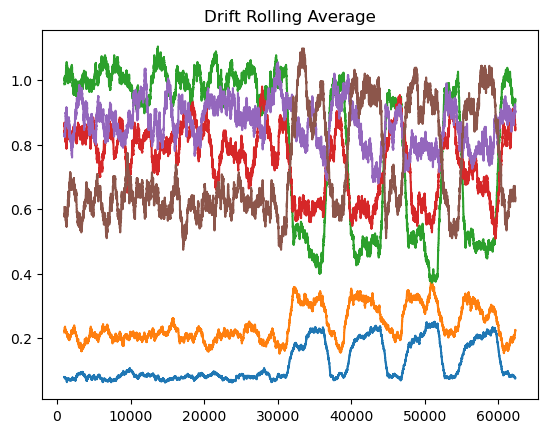

In [27]:

#dataframe after drift injection

df_drift = inject_gradual_drift(df, "type", "classification", "sudden", 4, "low",5000)
df_drift.iloc[drift_start_index:].head()

df_drift_1 = df_drift['type'].copy(deep=True).to_frame("type1_drift")
df_drift_2 = df_drift['type'].copy(deep=True).to_frame("type2_drift")
df_drift_3 = df_drift['type'].copy(deep=True).to_frame("type3_drift")
df_drift_4 = df_drift['type'].copy(deep=True).to_frame("type4_drift")
df_drift_5 = df_drift['type'].copy(deep=True).to_frame("type5_drift")
df_drift_6 = df_drift['type'].copy(deep=True).to_frame("type6_drift")


df_drift_1[df_drift_1['type1_drift'].isin([2,3,4,5,6])]=0
df_drift_2[df_drift_2['type2_drift'].isin([1,3,4,5,6])]=0
df_drift_3[df_drift_3['type3_drift'].isin([1,2,4,5,6])]=0
df_drift_4[df_drift_4['type4_drift'].isin([1,2,3,5,6])]=0
df_drift_5[df_drift_5['type5_drift'].isin([1,2,3,4,6])]=0
df_drift_6[df_drift_6['type6_drift'].isin([1,2,3,4,5])]=0


df_drift_viz = pd.concat([df_drift, df_drift_1,df_drift_2,df_drift_3,df_drift_4,df_drift_5,df_drift_6], axis=1)

df_drift_viz['type1_drift'].rolling(1000).mean().reset_index(drop=True).plot(title = "Drift Rolling Average")
df_drift_viz['type2_drift'].rolling(1000).mean().reset_index(drop=True).plot()
df_drift_viz['type3_drift'].rolling(1000).mean().reset_index(drop=True).plot()
df_drift_viz['type4_drift'].rolling(1000).mean().reset_index(drop=True).plot()
df_drift_viz['type5_drift'].rolling(1000).mean().reset_index(drop=True).plot()
df_drift_viz['type6_drift'].rolling(1000).mean().reset_index(drop=True).plot()

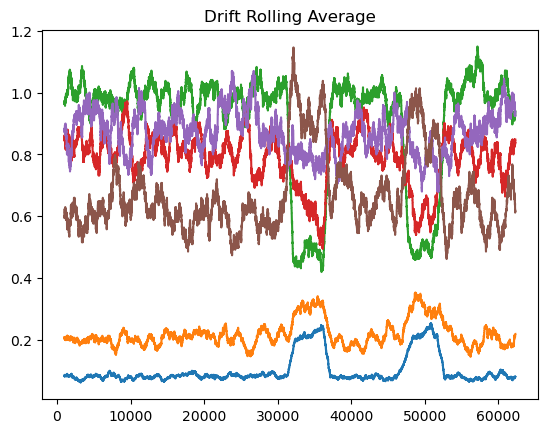

In [44]:

#dataframe after drift injection

df_drift = inject_gradual_drift(df, "type", "classification", "sudden", 2, "low",5000)
df_drift.iloc[drift_start_index:].head()

df_drift_1 = df_drift['type'].copy(deep=True).to_frame("type1_drift")
df_drift_2 = df_drift['type'].copy(deep=True).to_frame("type2_drift")
df_drift_3 = df_drift['type'].copy(deep=True).to_frame("type3_drift")
df_drift_4 = df_drift['type'].copy(deep=True).to_frame("type4_drift")
df_drift_5 = df_drift['type'].copy(deep=True).to_frame("type5_drift")
df_drift_6 = df_drift['type'].copy(deep=True).to_frame("type6_drift")


df_drift_1[df_drift_1['type1_drift'].isin([2,3,4,5,6])]=0
df_drift_2[df_drift_2['type2_drift'].isin([1,3,4,5,6])]=0
df_drift_3[df_drift_3['type3_drift'].isin([1,2,4,5,6])]=0
df_drift_4[df_drift_4['type4_drift'].isin([1,2,3,5,6])]=0
df_drift_5[df_drift_5['type5_drift'].isin([1,2,3,4,6])]=0
df_drift_6[df_drift_6['type6_drift'].isin([1,2,3,4,5])]=0


df_drift_viz = pd.concat([df_drift, df_drift_1,df_drift_2,df_drift_3,df_drift_4,df_drift_5,df_drift_6], axis=1)

df_drift_viz['type1_drift'].rolling(1000).mean().reset_index(drop=True).plot(title = "Drift Rolling Average")
df_drift_viz['type2_drift'].rolling(1000).mean().reset_index(drop=True).plot()
df_drift_viz['type3_drift'].rolling(1000).mean().reset_index(drop=True).plot()
df_drift_viz['type4_drift'].rolling(1000).mean().reset_index(drop=True).plot()
df_drift_viz['type5_drift'].rolling(1000).mean().reset_index(drop=True).plot()
df_drift_viz['type6_drift'].rolling(1000).mean().reset_index(drop=True).plot()


plt.savefig("GradualDriftInjection.png")